# SP22: MGMT ACCESS USE BIG DATA - Final Project

## Name : Akhila Sakiramolla (asakiram@iu.edu)
## UID : 2000886005

## Importing required libraries

In [1]:
# PySpark configuration
import sys
from pyspark.sql.functions  import *
from pyspark.sql.types import *
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from pyspark.sql.functions import col,isnan, when, count

In [2]:
# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.vq import kmeans, vq
import seaborn as sns
from matplotlib.lines import Line2D

In [3]:
# define the configurations 
conf = SparkConf().setMaster("local[*]").setAppName("Books")
conf.set("spark.executor.memory", "6G")
conf.set("spark.driver.memory", "2G")
conf.set("spark.executor.cores", "4")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.default.parallelism", "4")

In [4]:
spark = SparkSession.builder.config(conf = conf).appName("spark session").getOrCreate()

## Loading the data

In [5]:
# Loading the data and viewing it

books = spark.read.load("gs://bucket-finalproject-akhila/books.csv",
                          format = 'csv',
                          sep = ',',
                          header = 'true',
                          inferSchema = 'true').cache()
books.show(3)

+------+--------------------+--------------------+--------------+---------+-------+-------------+---------+-------------+------------------+----------------+---------------+
|bookID|               title|             authors|average_rating|     isbn| isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|
+------+--------------------+--------------------+--------------+---------+-------+-------------+---------+-------------+------------------+----------------+---------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|439785960|9.78E12|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|439358078|9.78E12|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|439554896|9.78E12|          eng|      352|         6333|         

In [6]:
print((books.count(), len(books.columns)))

(11127, 12)


In [7]:
books.printSchema()

root
 |-- bookID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- language_code: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- publication_date: string (nullable = true)
 |-- publisher: string (nullable = true)



## Checking for null values 

In [8]:
books.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in books.columns]).show()

+------+-----+-------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+
|bookID|title|authors|average_rating|isbn|isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|publisher|
+------+-----+-------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+
|     0|    0|      0|             0|   0|     0|            0|        0|            0|                 0|               0|        0|
+------+-----+-------+--------------+----+------+-------------+---------+-------------+------------------+----------------+---------+



## Checking for duplicate values

In [9]:
distinct_books = books.distinct()
print("Distinct count: "+str(distinct_books.count()))

Distinct count: 11127


In [10]:
distinct_books1 = books.dropDuplicates()
print("Distinct count: "+str(distinct_books1.count()))

Distinct count: 11127


## Data summary

In [11]:
from pyspark.sql.functions import format_number
result = books.select(["average_rating","num_pages","ratings_count","text_reviews_count"]).describe()
result.select(result['summary'],
              format_number(result['average_rating'].cast('float'),2).alias('average_rating'),
              result['num_pages'].cast('int').alias('num_pages'),
              result['ratings_count'].cast('int').alias('ratings_count'),
              result['text_reviews_count'].cast('int').alias('text_reviews_count')
             ).show()

+-------+--------------+---------+-------------+------------------+
|summary|average_rating|num_pages|ratings_count|text_reviews_count|
+-------+--------------+---------+-------------+------------------+
|  count|     11,127.00|    11127|        11127|             11127|
|   mean|          3.93|      336|        17936|               541|
| stddev|          0.35|      241|       112479|              2576|
|    min|          0.00|        0|            0|                 0|
|    max|          5.00|     6576|      4597666|             94265|
+-------+--------------+---------+-------------+------------------+



In [12]:
books.select("bookID").distinct().count()

11127

In [13]:
books.select("title").distinct().count()

10352

In [14]:
books.select("authors").distinct().count()

6643

In [15]:
books.select("language_code").distinct().count()

27

In [16]:
books.select("publisher").distinct().count()

2292

## Data preprocessing

In [17]:
books1 = books.toPandas()
df_books = pd.DataFrame(books1)
df_books.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,9/1/2004,Scholastic Inc.


In [18]:
df_books.dtypes

bookID                  int32
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                float64
language_code          object
num_pages               int32
ratings_count           int32
text_reviews_count      int32
publication_date       object
publisher              object
dtype: object

In [19]:
# Changing the data type of publication date from object to date
df_books['publication_date'] = pd.to_datetime(df_books['publication_date'], errors='coerce')
df_books['Year'] = df_books['publication_date'].dt.year

In [20]:
df_books['publication_date'].min()

Timestamp('1900-01-01 00:00:00')

In [21]:
df_books['publication_date'].max()

Timestamp('2020-03-31 00:00:00')

In [22]:
df_books[df_books.duplicated()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Year


In [23]:
df_books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
Year                  2
dtype: int64

In [24]:
df_books = df_books[df_books['publication_date'].notna()]
df_books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
Year                  0
dtype: int64

## Preliminary data analysis

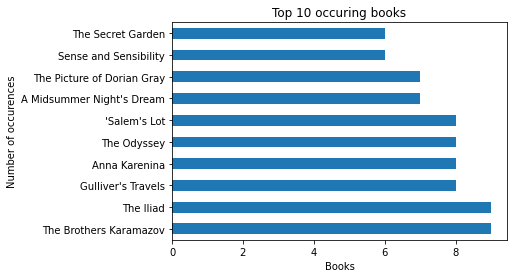

In [25]:
# Plotting top 10 occuring books 

df_books['title'].value_counts()[0:10].plot(kind='barh')
plt.ylabel("Number of occurences")
plt.xlabel("Books")
plt.title("Top 10 occuring books")
plt.show()

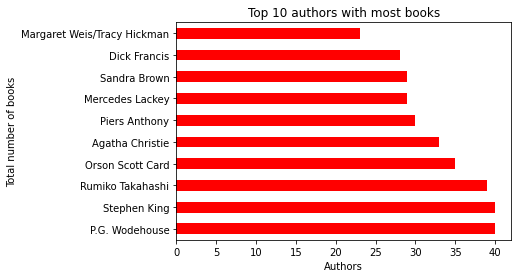

In [26]:
# Plotting top 10 authors 

df_books['authors'].value_counts()[0:10].plot(kind='barh', color = 'red')
plt.ylabel("Total number of books")
plt.xlabel("Authors")
plt.title("Top 10 authors with most books")
plt.show()

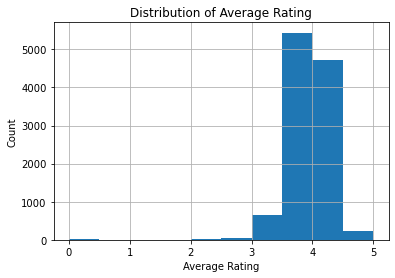

In [27]:
# Plotting the distribution of average rating

df_books.hist(column='average_rating')
plt.ylabel("Count")
plt.xlabel("Average Rating")
plt.title("Distribution of Average Rating")
plt.show()

In [28]:
def ratingsGroup(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

11125


Text(0.5, 1.0, 'Distribution of Average Rating')

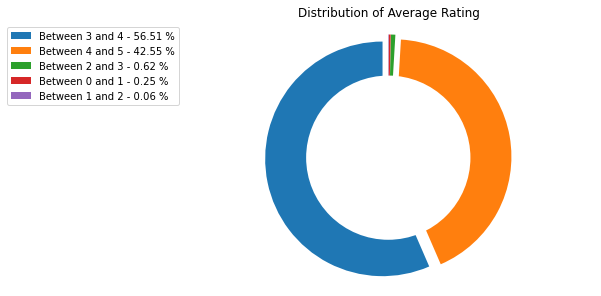

In [41]:
df_books['Ratings_Dist'] = ratingsGroup(df_books)
ratings_pie = df_books['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
# colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],
#         colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))

#Draw a circle now
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0., 1.),)
plt.title("Distribution of Average Rating")

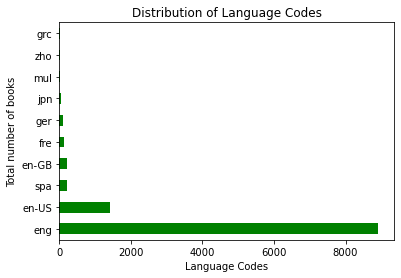

In [30]:
# Plotting top 10 authors 

df_books['language_code'].value_counts()[0:10].plot(kind='barh', color = 'green')
plt.ylabel("Total number of books")
plt.xlabel("Language Codes")
plt.title("Distribution of Language Codes")
plt.show()

In [31]:
# Creating a new variable for age groups

df_books.loc[(df_books['num_pages'] < 50), 'page_numbers'] = 50
df_books.loc[(df_books['num_pages'] >= 50) & (df_books['num_pages'] < 150), 'page_numbers'] = 100
df_books.loc[(df_books['num_pages'] >= 150) & (df_books['num_pages'] < 250), 'page_numbers'] = 200
df_books.loc[(df_books['num_pages'] >= 250) & (df_books['num_pages'] < 350), 'page_numbers'] = 300
df_books.loc[(df_books['num_pages'] >= 350) & (df_books['num_pages'] < 450), 'page_numbers'] = 400
df_books.loc[(df_books['num_pages'] >= 450) & (df_books['num_pages'] < 550), 'page_numbers'] = 500
df_books.loc[(df_books['num_pages'] >= 550) & (df_books['num_pages'] < 650), 'page_numbers'] = 600
df_books.loc[(df_books['num_pages'] >= 650) & (df_books['num_pages'] < 750), 'page_numbers'] = 700
df_books.loc[(df_books['num_pages'] >= 750) & (df_books['num_pages'] < 850), 'page_numbers'] = 800
df_books.loc[(df_books['num_pages'] >= 850) & (df_books['num_pages'] < 950), 'page_numbers'] = 900
df_books.loc[(df_books['num_pages'] >= 950), 'page_numbers'] = 1000

df_books['page_numbers'].value_counts()

300.0     2573
200.0     2546
400.0     2029
100.0     1160
500.0      885
50.0       568
600.0      514
700.0      290
1000.0     247
800.0      205
900.0      108
Name: page_numbers, dtype: int64

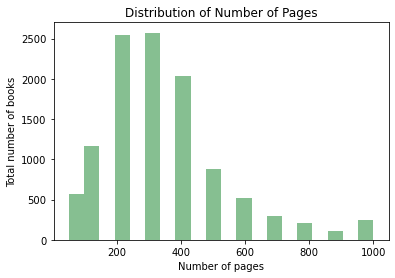

In [45]:
# Plotting the distribution of average rating

df_books.hist(column='page_numbers', bins=20, grid=False, figsize=(6,4), color='#86bf91')
plt.ylabel("Total number of books")
plt.xlabel("Number of pages")
plt.title("Distribution of Number of Pages")
plt.show()

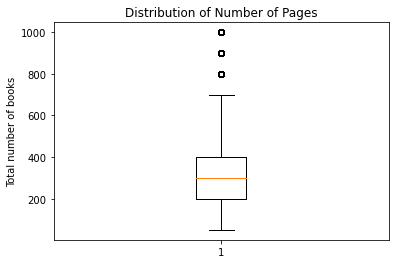

In [47]:
# Plotting boxplot for the distribution of average rating

fig = plt.figure(figsize =(6, 4))
plt.boxplot(df_books['page_numbers'])
plt.ylabel("Total number of books")
plt.title("Distribution of Number of Pages")
plt.show()

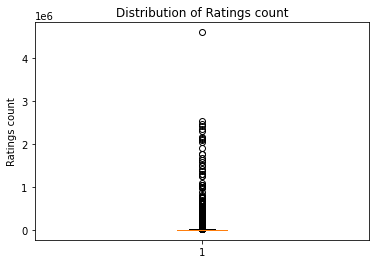

In [48]:
# Plotting the distribution of ratings count

fig = plt.figure(figsize =(6, 4))
plt.boxplot(df_books['ratings_count'])
plt.ylabel("Ratings count")
plt.title("Distribution of Ratings count")
plt.show()

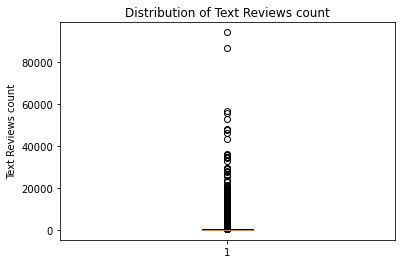

In [49]:
# Plotting the distribution of text ratings count

fig = plt.figure(figsize =(6, 4))
plt.boxplot(df_books['text_reviews_count'])
plt.ylabel("Text Reviews count")
plt.title("Distribution of Text Reviews count")
plt.show()

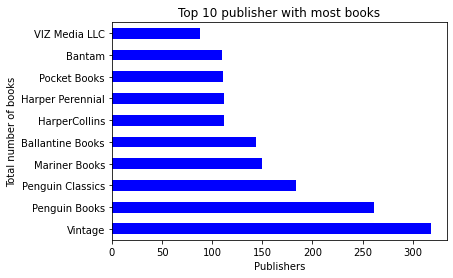

In [36]:
# Plotting top 10 publishers 

df_books['publisher'].value_counts()[0:10].plot(kind='barh', color = 'blue')
plt.ylabel("Total number of books")
plt.xlabel("Publishers")
plt.title("Top 10 publisher with most books")
plt.show()

### Bivariate Analysis

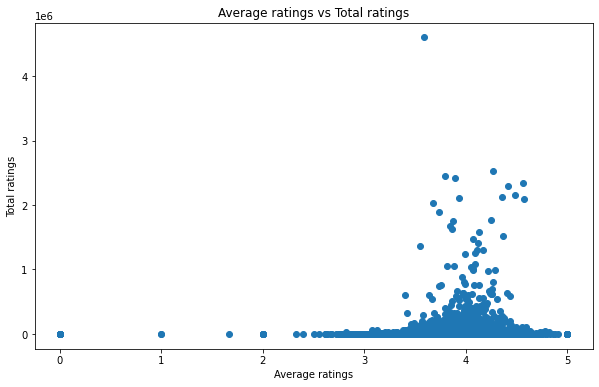

In [70]:
# Plotting the relationship between average ratings and ratings count

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_books['average_rating'], df_books['ratings_count'])
plt.title('Average ratings vs Total ratings')
plt.xlabel('Average ratings')
plt.ylabel('Total ratings')
plt.show()

In [65]:
q_low = df_books["ratings_count"].quantile(0.25)
q_hi  = df_books["ratings_count"].quantile(0.75)

df_filtered = df_books[(df_books["ratings_count"] < q_hi) & (df_books["ratings_count"] > q_low)]

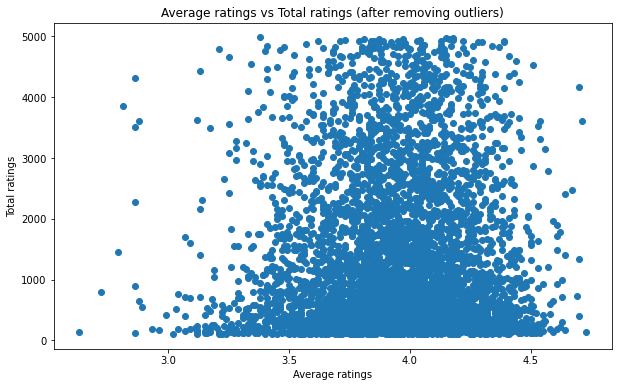

In [69]:
# Plotting the relationship between average ratings and ratings count after removing outliers

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_filtered['average_rating'], df_filtered['ratings_count'])
plt.title('Average ratings vs Total ratings (after removing outliers)')
plt.xlabel('Average ratings')
plt.ylabel('Total ratings')
plt.show()

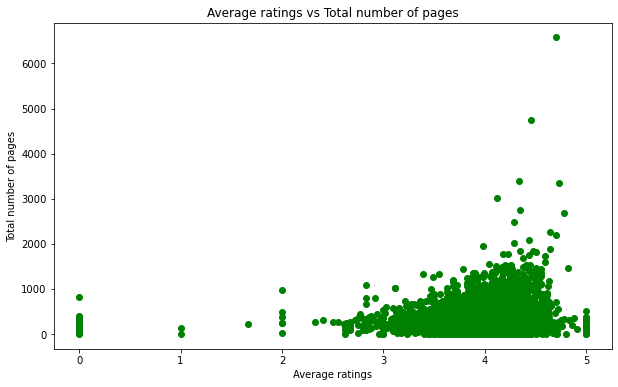

In [71]:
# Plotting the relationship between average ratings and number of pages 

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_books['average_rating'], df_books['num_pages'], color = 'green')
plt.title('Average ratings vs Total number of pages')
plt.xlabel('Average ratings')
plt.ylabel('Total number of pages')
plt.show()

In [72]:
q_low = df_books["num_pages"].quantile(0.25)
q_hi  = df_books["num_pages"].quantile(0.75)

df_filtered = df_books[(df_books["num_pages"] < q_hi) & (df_books["num_pages"] > q_low)]

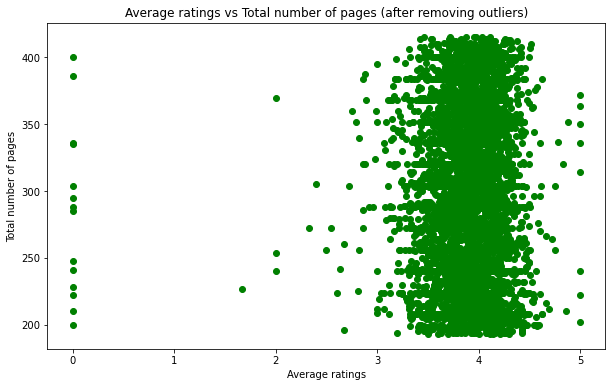

In [75]:
# Plotting the relationship between average ratings and number of pages after removing outliers

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_filtered['average_rating'], df_filtered['num_pages'], color = 'green')
plt.title('Average ratings vs Total number of pages (after removing outliers)')
plt.xlabel('Average ratings')
plt.ylabel('Total number of pages')
plt.show()

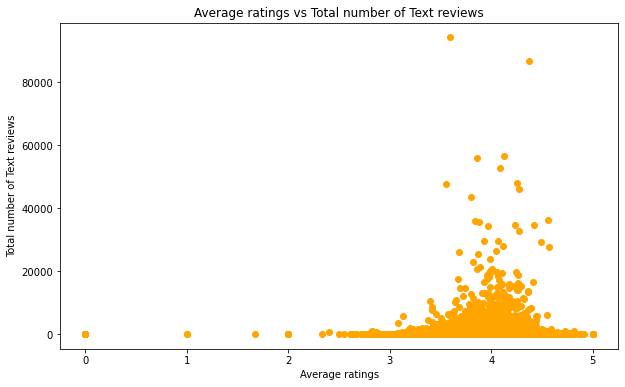

In [76]:
# Plotting the relationship between average ratings and number of text reviews 

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_books['average_rating'], df_books['text_reviews_count'], color = 'orange')
plt.title('Average ratings vs Total number of Text reviews')
plt.xlabel('Average ratings')
plt.ylabel('Total number of Text reviews')
plt.show()

In [77]:
q_low = df_books["text_reviews_count"].quantile(0.25)
q_hi  = df_books["text_reviews_count"].quantile(0.75)

df_filtered = df_books[(df_books["text_reviews_count"] < q_hi) & (df_books["text_reviews_count"] > q_low)]

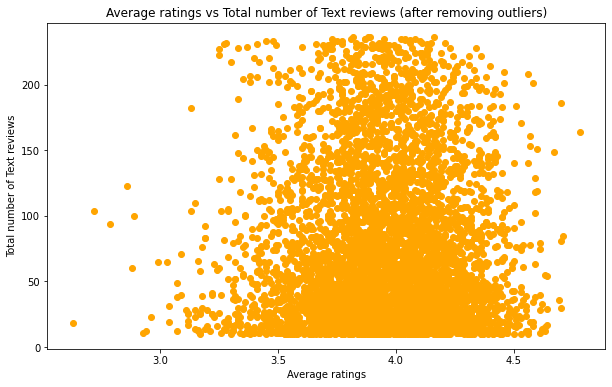

In [78]:
# Plotting the relationship between average ratings and number of text reviews after removing outliers

fig = plt.figure(figsize =(10, 6))
plt.scatter(df_filtered['average_rating'], df_filtered['text_reviews_count'], color = 'orange')
plt.title('Average ratings vs Total number of Text reviews (after removing outliers)')
plt.xlabel('Average ratings')
plt.ylabel('Total number of Text reviews')
plt.show()

In [79]:
df_year = df_books.groupby('Year').agg({'average_rating':'mean', 'ratings_count':'mean'})
df_year.reset_index(inplace = True)
df_year.head()

,Year,average_rating,ratings_count
0,1900.0,3.88,332.0
1,1913.0,3.96,111.0
2,1914.0,3.95,87.0
3,1919.0,4.32,208.0
4,1921.0,4.14,29.5


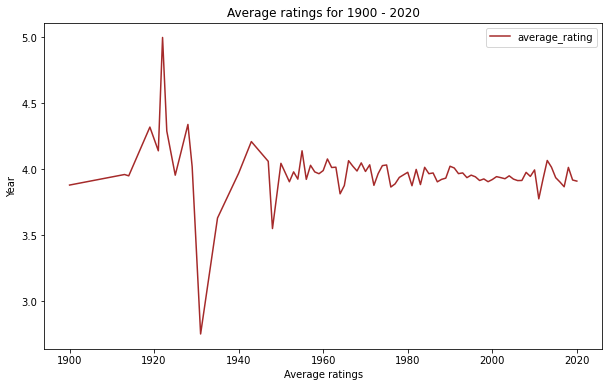

In [80]:
df_year.plot(x='Year', y='average_rating', figsize=(10,6), color = 'brown')
plt.title('Average ratings for 1900 - 2020')
plt.xlabel('Average ratings')
plt.ylabel('Year')
plt.show()

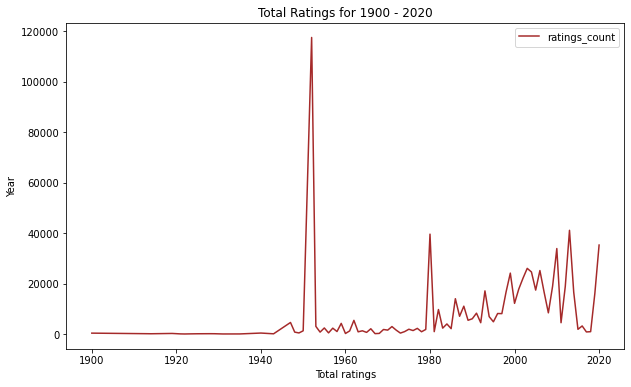

In [81]:
df_year.plot(x='Year', y='ratings_count', figsize=(10,6), color = 'brown')
plt.title('Total Ratings for 1900 - 2020')
plt.xlabel('Total ratings')
plt.ylabel('Year')
plt.show()

In [82]:
trial = df_books[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T

## Topic Modelling

Reference : https://www.kaggle.com/code/hoshi7/goodreads-analysis-and-recommending-books

Text(0.5, 1.0, 'Elbow Curve')

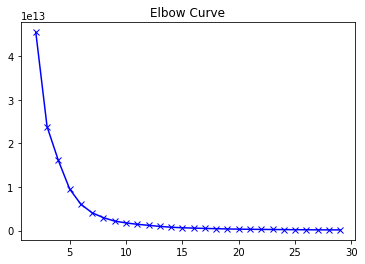

In [85]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(6,4))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [86]:
#Computing K means with K = 5, thus, taking it as 5 clusters
centroids, _ = kmeans(data, 5)

#Vector Quantisation:

idx, _ = vq(data, centroids)

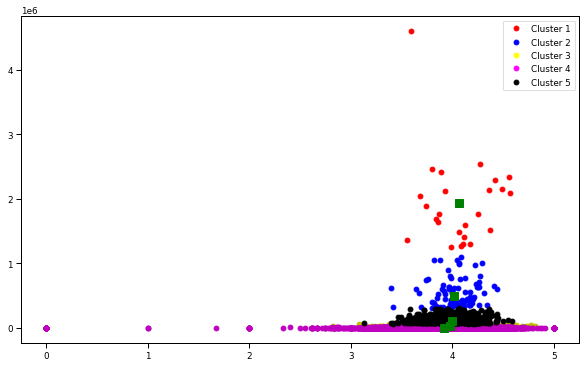

In [88]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(10,6))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )
circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5), ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), 
           numpoints = 1, loc = 0, )
plt.show()

In [89]:
books_features = pd.concat([df_books['Ratings_Dist'].str.get_dummies(sep=","), df_books['average_rating'], df_books['ratings_count']], axis=1)

In [90]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
0,0,0,0,0,1,4.57,2095690
1,0,0,0,0,1,4.49,2153167
2,0,0,0,0,1,4.42,6333
3,0,0,0,0,1,4.56,2339585
4,0,0,0,0,1,4.78,41428


In [91]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [92]:
np.round(books_features, 2)

array([[0.  , 0.  , 0.  , ..., 1.  , 0.91, 0.46],
       [0.  , 0.  , 0.  , ..., 1.  , 0.9 , 0.47],
       [0.  , 0.  , 0.  , ..., 1.  , 0.88, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.79, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.74, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.78, 0.  ]])

In [93]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

In [94]:
def get_index_from_name(name):
    return df_books[df_books["title"]==name].index.tolist()[0]

all_books_names = list(df_books.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df_books.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df_books.iloc[id]["title"])

## Finding similar books - recommendations

In [95]:
print_similar_books("The Catcher in the Rye")

Angels & Demons (Robert Langdon  #1)
Animal Farm
Lord of the Flies
Romeo and Juliet
Of Mice and Men


In [96]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 8875
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 10677
Harry Potter and the Goblet of Fire (Harry Potter  #4) 10678


In [97]:
print_similar_books(id = 1) #ID for the Book 5

Harry Potter and the Half-Blood Prince (Harry Potter  #6)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Hobbit  or There and Back Again
